<a href="https://colab.research.google.com/github/rydr0/Sat_Image_Dataset/blob/master/TrainClassification_6classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive - necessary for model checkpointing and loading
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Imports and setup

In [ ]:
# Check which GPU using on Google colab
!nvidia-smi

Mon Sep  7 01:13:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Load Github Repository with Satellite Images, Population Labels and Helper files
! git clone https://github.com/rydr0/Sat_Image_Dataset.git

Cloning into 'Sat_Image_Dataset'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 138625 (delta 41), reused 57 (delta 21), pack-reused 138545
Receiving objects: 100% (138625/138625), 1.35 GiB | 14.60 MiB/s, done.
Resolving deltas: 100% (71323/71323), done.
Checking out files: 100% (92905/92905), done.


In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-s

In [ ]:
# Install third-party libraries
!pip install pytorch.ignite
!pip install geopandas
!pip install gdal

     |████████████████████████████████| 174kB 2.6MB/s 
     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 10.9MB 15.2MB/s 
     |████████████████████████████████| 14.8MB 207kB/s 


In [ ]:
# Import packages
from torchsummary import summary
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sys
import geopandas as gpd
import gdal
import pprint


from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import ModelCheckpoint, Checkpoint

%matplotlib inline

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-fonts-extra is already the newest version (2017.20180305-2).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-fonts-extra is already the newest version (2017.20180305-2).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to r

In [ ]:
# Load functions from Helper Files
sys.path.append('/content/Sat_Image_Dataset')
from DatasetandDataLoader import *
from Helpers import *
from Training_Classification import *
from Visualisation import *
from Neural_Network import *

# Load Datasets

In [ ]:
# Load dataset to be used in training
train_dataset_model, test_dataset, sat_mean, sat_std = load_datasets(flip=False, classes=6)

Mean for image channels:
tensor([[[[ 481.4347]],

         [[ 661.0318]],

         [[ 633.2782]],

         [[2610.5615]],

         [[1754.3627]],

         [[2808.4644]],

         [[ 987.0544]]]], dtype=torch.float64)
Standard deviation for image channels:
tensor([[[[182.0427]],

         [[221.7736]],

         [[282.7514]],

         [[989.6967]],

         [[604.5539]],

         [[463.1821]],

         [[403.9931]]]], dtype=torch.float64)
NAN pixel values found and replaced:1944166
Percentage of total pixels:0.026403685596329832
Training Set Images: 37994
NAN pixel values found and replaced:442414
Percentage of total pixels:0.025244303949147805
Test Set Images: 8450


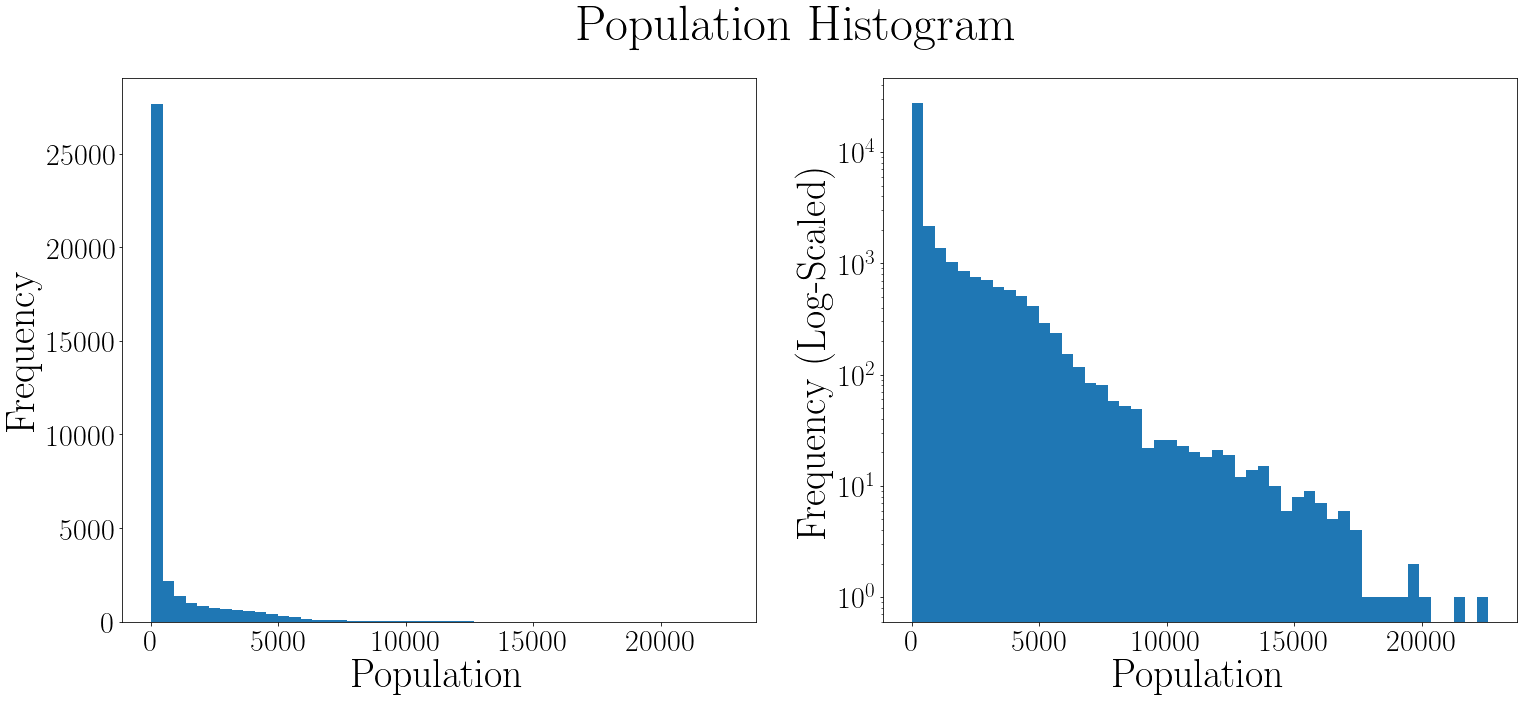

In [ ]:
hist1 = population_hist(train_dataset_model, bins=50)
plt.savefig("Population Hist - Tr")

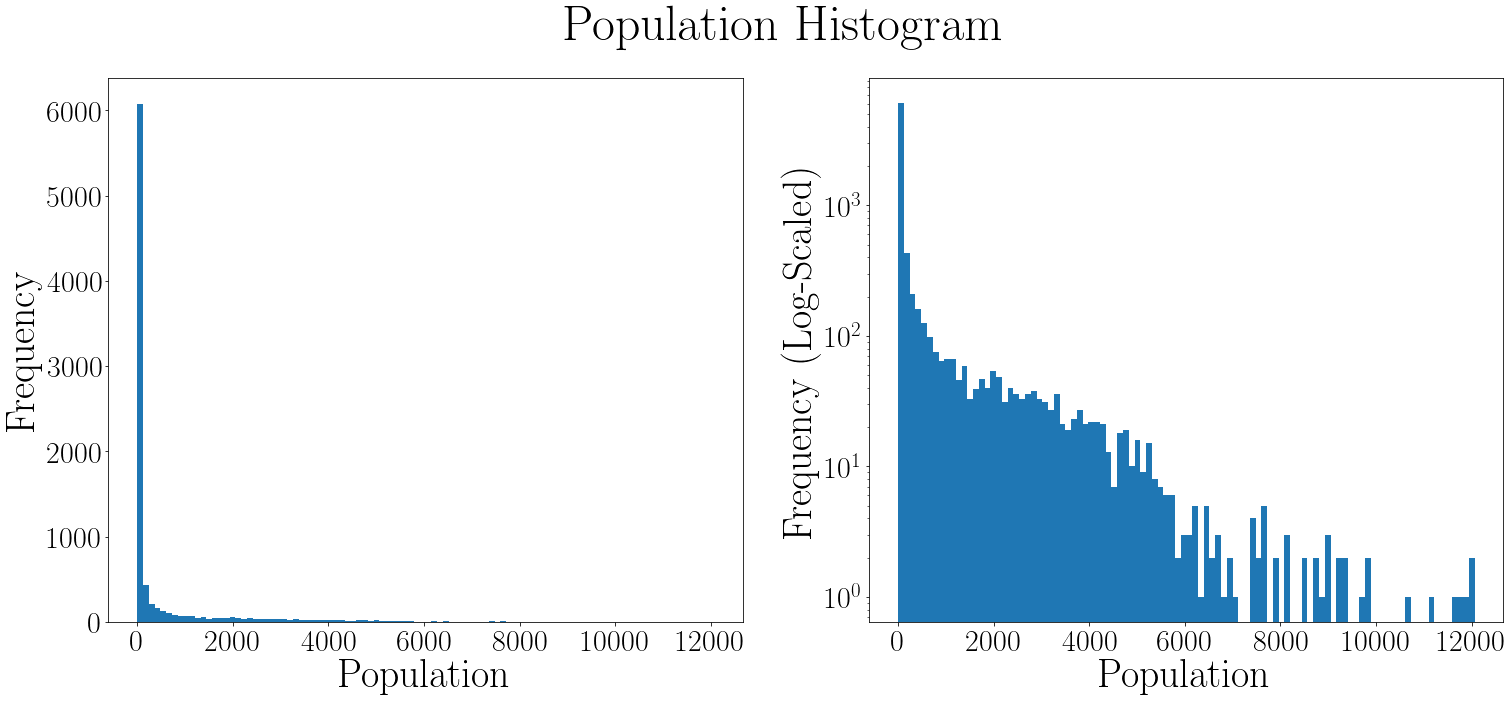

<Figure size 432x288 with 0 Axes>

In [ ]:
hist1 = population_hist(test_dataset, bins=100)
plt.show()
plt.savefig("Population Hist - Tst")

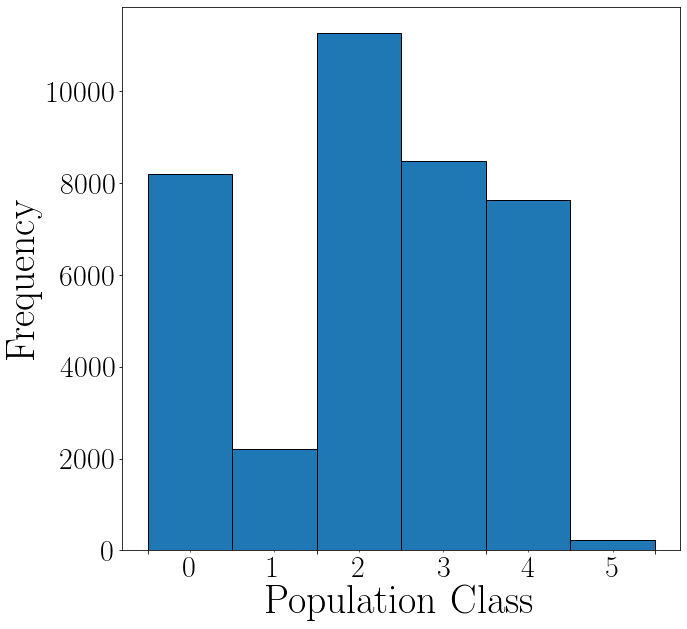

In [ ]:
hist2 = class_hist(train_dataset_model, classes=6)
plt.ylabel("Frequency")
plt.xlabel("Population Class")
plt.savefig('Pop Class Hist - Tr')
plt.show()

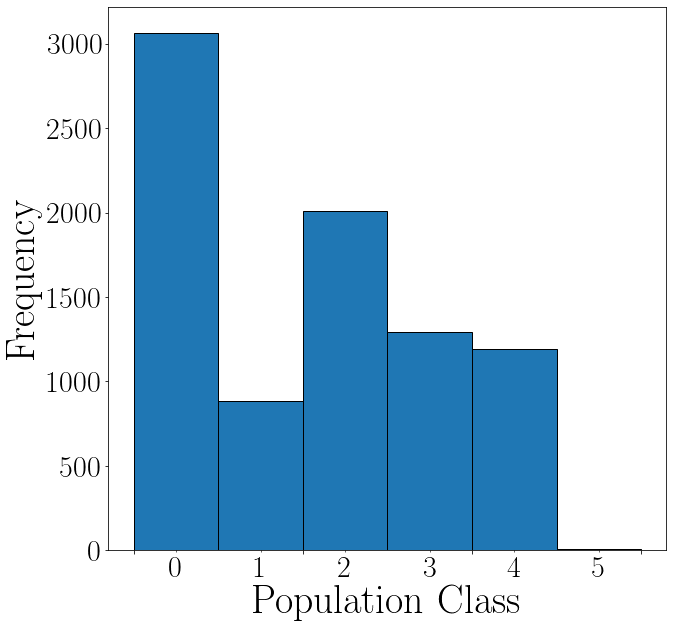

In [ ]:
hist3 = class_hist(test_dataset, classes=6)
plt.ylabel("Frequency")
plt.xlabel("Population Class")
plt.savefig('Pop Class Hist - Tst')
plt.show()

# Prepare DataLoader, Batches and Hyperparameters

In [ ]:
num_samples = len(train_dataset_model)
train_samples = int(len(train_dataset_model) * 0.9) # representing 90/10 train/val split
val_samples = num_samples - train_samples
print("""Total Samples: {total}
Training Samples: {train}
Validation Samples: {val}""".format(total=num_samples, train=train_samples, val=val_samples))

Total Samples: 37994
Training Samples: 34194
Validation Samples: 3800


In [ ]:
seed = 121
np.random.seed = seed
torch.manual_seed(seed)
indices = np.arange(num_samples)
np.random.shuffle(indices)

In [ ]:
def make_weights_for_balanced_classes(dataset, nclasses):
    count = [0] * nclasses
    cl_list = []
    print(count)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    iter_loader_test = iter(loader)
    for i in range(0, len(loader)):
        image, label = iter_loader_test.next()
        cl = int(label[0][2].item())
        count[cl] += 1
        cl_list.append(cl)
    print(count)
    print(cl_list)
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N / float(count[i])
    weight = [0] * len(dataset)
    print(weight_per_class)
    for i in range(0, len(loader)):
        weight[i] = weight_per_class[cl_list[i]]
    print(weight)
    return weight

In [ ]:
train_subset = torch.utils.data.Subset(train_dataset_model, indices[:train_samples])
balance_weights = make_weights_for_balanced_classes(train_subset, 6)

[0, 0, 0, 0, 0, 0]
[7341, 1973, 10157, 7614, 6898, 211]
[4, 1, 2, 2, 3, 4, 3, 4, 0, 2, 0, 3, 4, 0, 2, 3, 0, 3, 3, 0, 1, 2, 2, 3, 3, 3, 0, 0, 1, 4, 3, 4, 4, 0, 4, 2, 2, 0, 2, 0, 4, 0, 4, 3, 0, 3, 4, 2, 4, 3, 0, 2, 3, 2, 4, 3, 4, 0, 4, 2, 0, 0, 1, 2, 4, 3, 3, 2, 2, 4, 2, 0, 0, 4, 3, 3, 4, 4, 3, 2, 3, 3, 2, 3, 2, 1, 0, 2, 0, 4, 2, 0, 4, 3, 2, 2, 3, 2, 3, 0, 5, 2, 0, 2, 0, 2, 2, 0, 4, 0, 4, 2, 2, 4, 2, 2, 4, 0, 2, 4, 3, 1, 0, 0, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 0, 2, 1, 0, 0, 0, 2, 3, 2, 2, 3, 2, 4, 4, 4, 2, 3, 3, 0, 1, 4, 3, 2, 3, 2, 3, 3, 3, 0, 2, 3, 2, 4, 0, 3, 4, 4, 4, 2, 2, 0, 1, 2, 4, 2, 4, 4, 2, 3, 2, 0, 2, 1, 2, 3, 2, 0, 3, 2, 0, 0, 3, 4, 1, 0, 0, 0, 2, 2, 0, 4, 0, 0, 4, 3, 3, 4, 2, 3, 3, 4, 0, 4, 2, 3, 0, 0, 2, 3, 0, 2, 4, 2, 0, 4, 2, 3, 4, 3, 4, 0, 0, 3, 4, 2, 0, 2, 3, 2, 2, 3, 0, 2, 2, 0, 4, 2, 0, 0, 4, 0, 0, 0, 1, 2, 2, 3, 4, 4, 4, 0, 3, 2, 0, 2, 3, 2, 0, 3, 4, 0, 4, 2, 4, 3, 4, 0, 3, 3, 3, 0, 0, 3, 4, 0, 2, 4, 3, 3, 4, 4, 0, 2, 0, 3, 4, 2, 0, 3, 1, 3, 3, 4, 4, 2, 2, 4, 4, 3, 0

In [ ]:
balance_weights = torch.DoubleTensor(balance_weights)
tr_sampler = torch.utils.data.SubsetRandomSampler(indices[:train_samples])
val_sampler = torch.utils.data.SubsetRandomSampler(indices[train_samples:num_samples])
tr_sampler_balanced = torch.utils.data.sampler.WeightedRandomSampler(balance_weights, len(balance_weights), replacement=True) 

TypeError: ignored

In [ ]:
tr_batch_size = 512
val_batch_size = val_samples

train_loader = torch.utils.data.DataLoader(train_dataset_model,
                                           batch_size=tr_batch_size,
                                           shuffle=False,
                                           sampler=tr_sampler,
                                           num_workers = 4,
                                           pin_memory=True)

train_loader_balanced = torch.utils.data.DataLoader(train_subset,
                                           batch_size=tr_batch_size,
                                           shuffle=False,
                                           sampler=tr_sampler_balanced,
                                           num_workers = 4,
                                           pin_memory=True)

val_loader = torch.utils.data.DataLoader(train_dataset_model,
                                         batch_size=val_batch_size,
                                         shuffle=False,
                                         sampler=val_sampler,
                                         num_workers = 4,
                                          pin_memory=True)

In [ ]:
print("""Number of Training Batches: {tr_batch}
Number of Validation Batches: {val_batch}""".format(tr_batch=len(train_loader),
                                                    val_batch=len(val_loader)))

Number of Training Batches: 67
Number of Validation Batches: 1


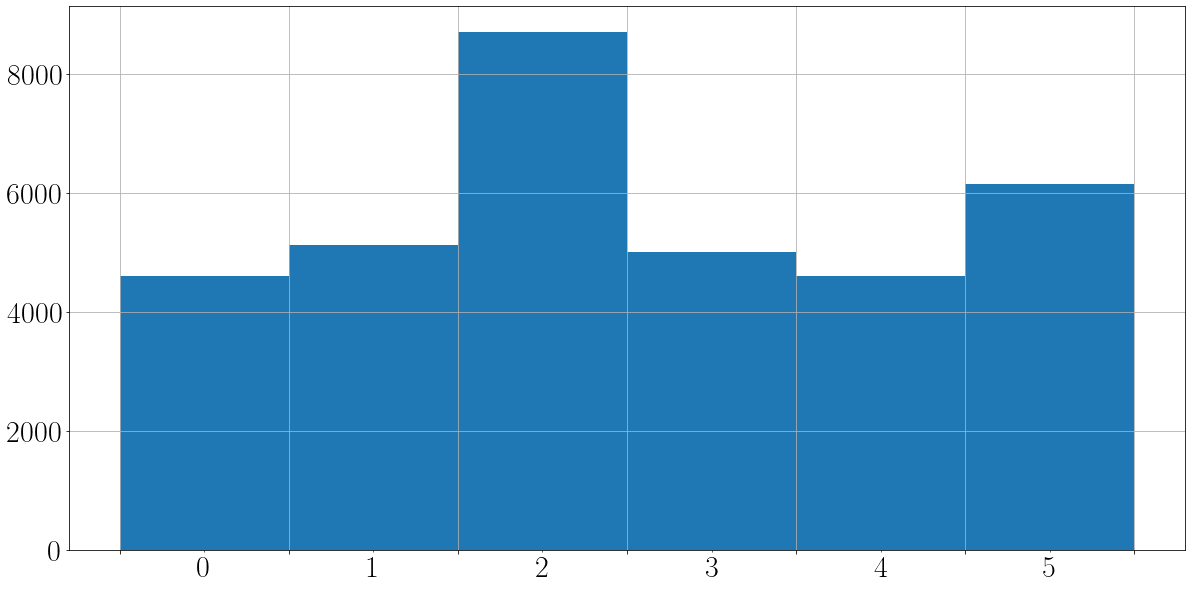

In [ ]:
balanced_hist = balanced_class_hist(train_loader_balanced, classes=6)

# Results

## Model - 6 classes

### Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Neural_Network(config='16', batch_norm=True)
parameters = torch.load('/content/drive/My Drive/Dissertation Files/Models/16layersflip_FinalEpoch50')
model.load_state_dict(parameters['model'])

# freeze the other layers
for param in model.parameters():
    param.requires_grad = False

model.fclayers[6] = nn.Linear(in_features=4096, out_features=6, bias=True) # change last linear layer to 6 output nodes 
model = model.float()
model.to(device)

print("Model Loaded")

Model Loaded


In [ ]:
model_result = run_training(model,
                            dataset=train_dataset_model,
                            t_loader=train_loader,
                            v_loader=val_loader,
                            max_epochs=20,
                            initial_lr=0.001,
                            flip=True,
                            flip_prob=0.25,
                            pbar=False,
                            checkpoint=False,
                            save_as="classification_6classes",
                            weight_decay=1e-5)

Epoch: 1
Training   | Avg loss: 0.6034 | Accuracy: 77.37% | Fbeta: 0.6542
Validation | Avg loss: 0.5863 | Accuracy: 78.08% | Fbeta: 0.6684
Epoch: 2
Training   | Avg loss: 0.5939 | Accuracy: 77.50% | Fbeta: 0.6441
Validation | Avg loss: 0.5788 | Accuracy: 78.53% | Fbeta: 0.6657
Epoch: 3
Training   | Avg loss: 0.6112 | Accuracy: 76.61% | Fbeta: 0.6567
Validation | Avg loss: 0.5901 | Accuracy: 77.71% | Fbeta: 0.6737
Epoch: 4
Training   | Avg loss: 0.6036 | Accuracy: 76.69% | Fbeta: 0.6424
Validation | Avg loss: 0.5877 | Accuracy: 77.37% | Fbeta: 0.6599
Epoch: 5
Training   | Avg loss: 0.5980 | Accuracy: 76.63% | Fbeta: 0.6468
Validation | Avg loss: 0.5820 | Accuracy: 77.84% | Fbeta: 0.6647
Epoch: 6
Training   | Avg loss: 0.6046 | Accuracy: 76.94% | Fbeta: 0.6464
Validation | Avg loss: 0.5893 | Accuracy: 77.82% | Fbeta: 0.6667
Epoch: 7
Training   | Avg loss: 0.6010 | Accuracy: 77.20% | Fbeta: 0.6557
Validation | Avg loss: 0.5866 | Accuracy: 78.08% | Fbeta: 0.6791
Epoch: 8
Training   | Avg l

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


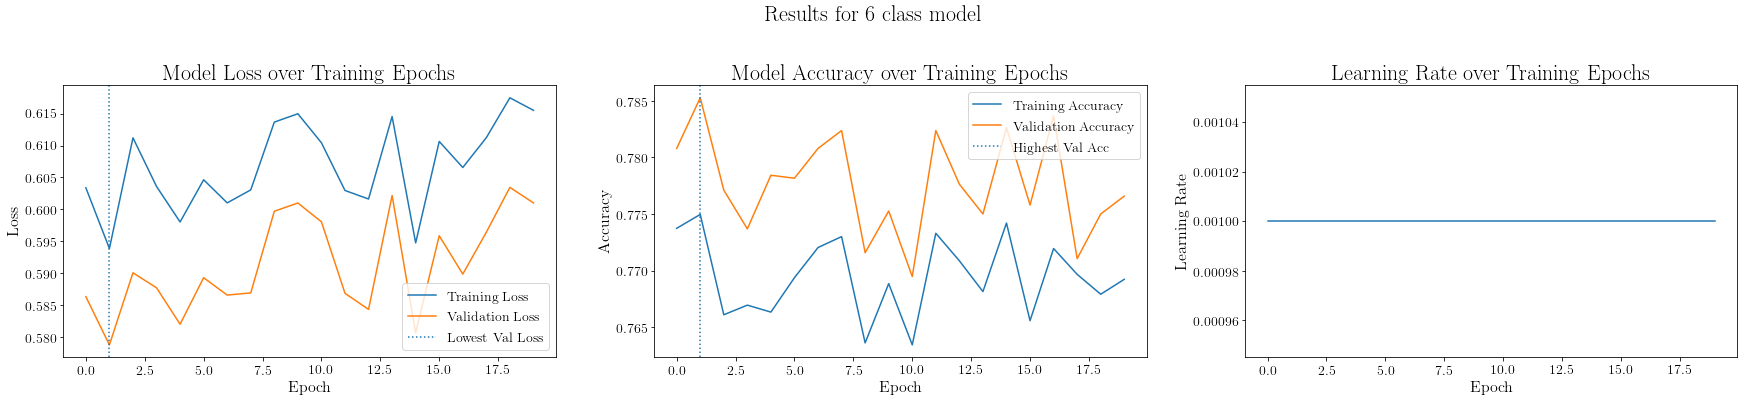

Lowest Validation Loss: 0.5788 - Epoch: 1
Highest Validation Accuracy: 78.5263% - Epoch 1


In [ ]:
small_fonts()
plot_results_cl(model_result, "Results for 6 class model")

### Results

In [ ]:
train_dataset_model.flip = False
model_result_tr = test_classification(model, train_dataset_model, train_dataset_model.n_images, device)

Overall Accuracy (Top 1, Top 2, Top 3): 78.325525%, 88.835079%, 92.467232%
    
Accuracy: 78.33%
    
Balanced Accuracy: 66.13%
    
F1 Score: 0.76
    

    
              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80      8185
         1.0       0.00      0.00      0.00      2204
         2.0       0.65      0.87      0.74     11271
         3.0       0.82      0.78      0.80      8474
         4.0       0.94      0.94      0.94      7631
         5.0       0.80      0.64      0.71       229

    accuracy                           0.78     37994
   macro avg       0.68      0.66      0.67     37994
weighted avg       0.75      0.78      0.76     37994



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_results_tst = test_classification(model, test_dataset, test_dataset.n_images, device)

Overall Accuracy (Top 1, Top 2, Top 3): 66.248521%, 80.781065%, 88.449704%
    
Accuracy: 66.25%
    
Balanced Accuracy: 50.26%
    
F1 Score: 0.64
    

    
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.75      3065
         1.0       0.00      0.00      0.00       886
         2.0       0.45      0.74      0.56      2008
         3.0       0.70      0.66      0.68      1292
         4.0       0.92      0.90      0.91      1192
         5.0       0.00      0.00      0.00         7

    accuracy                           0.66      8450
   macro avg       0.48      0.50      0.48      8450
weighted avg       0.63      0.66      0.64      8450



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


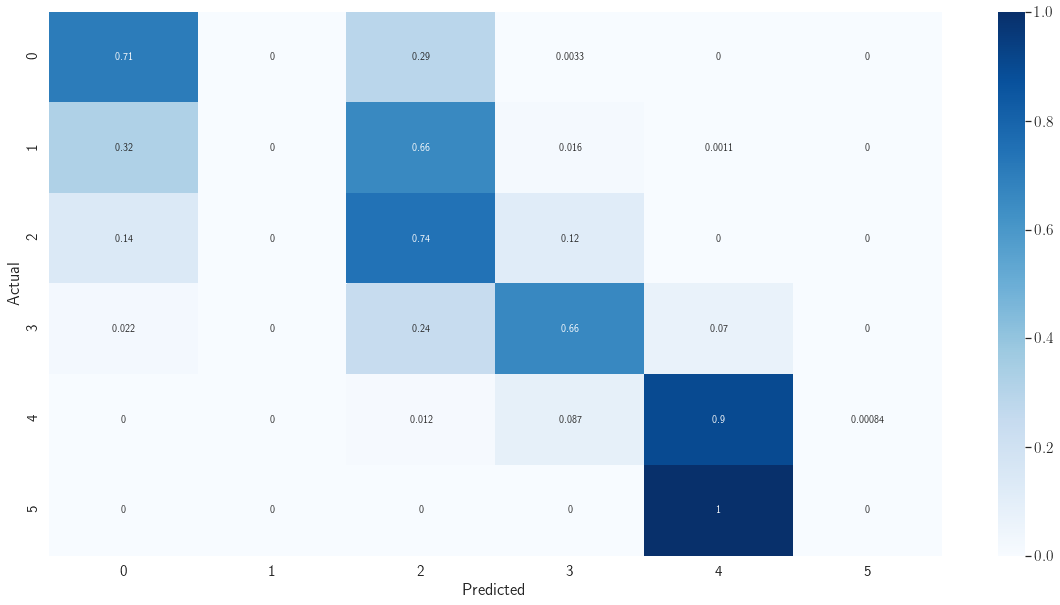

In [ ]:
confusion_matrix(model_results_tst)

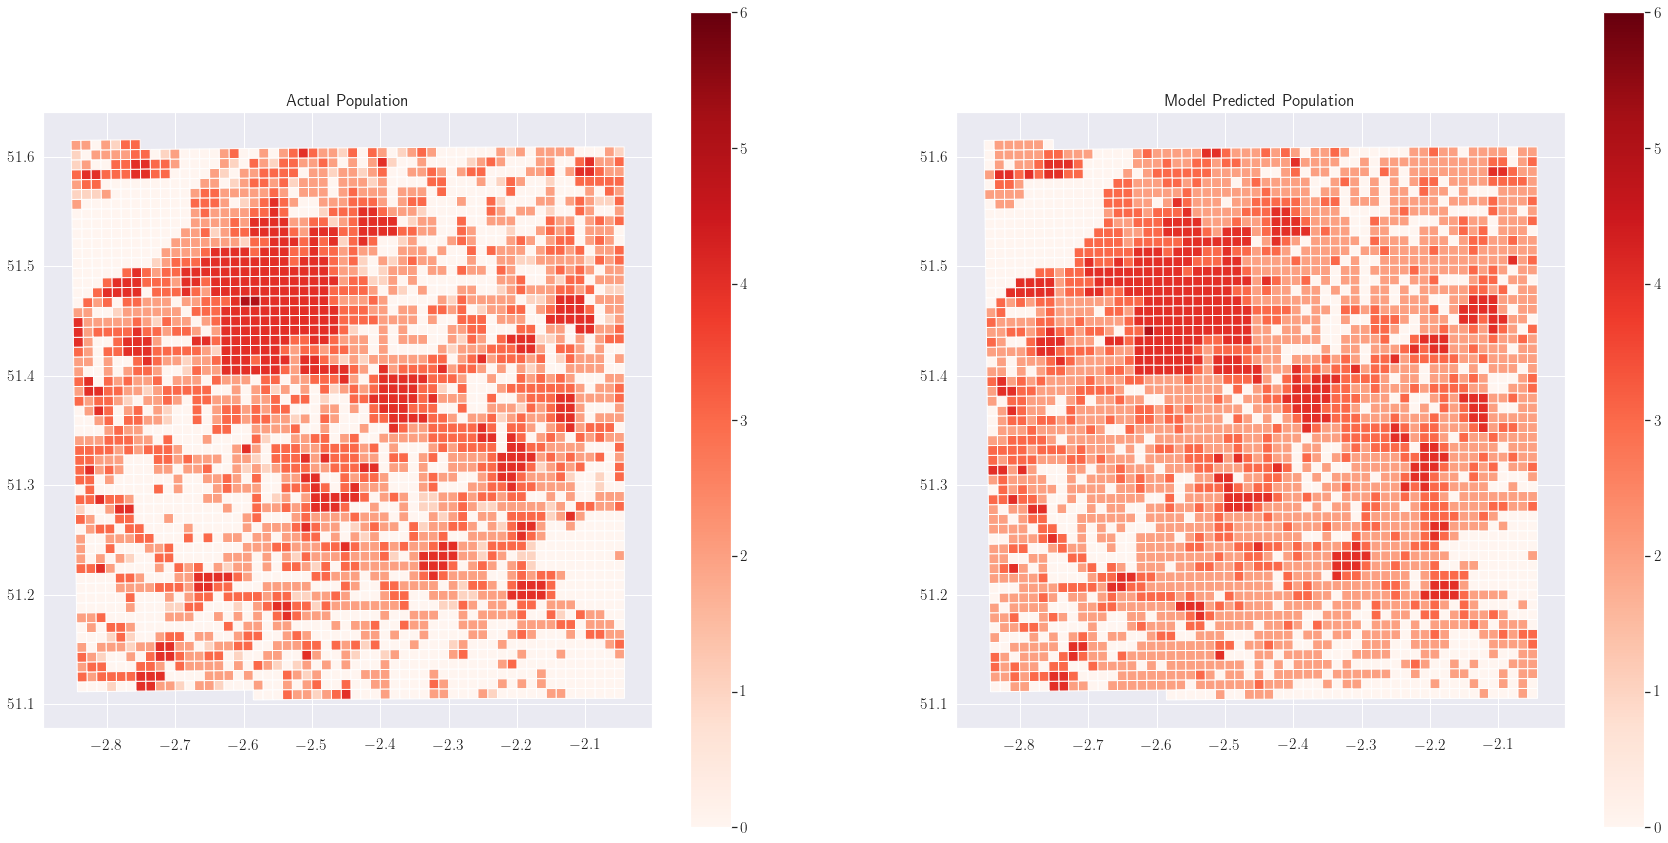

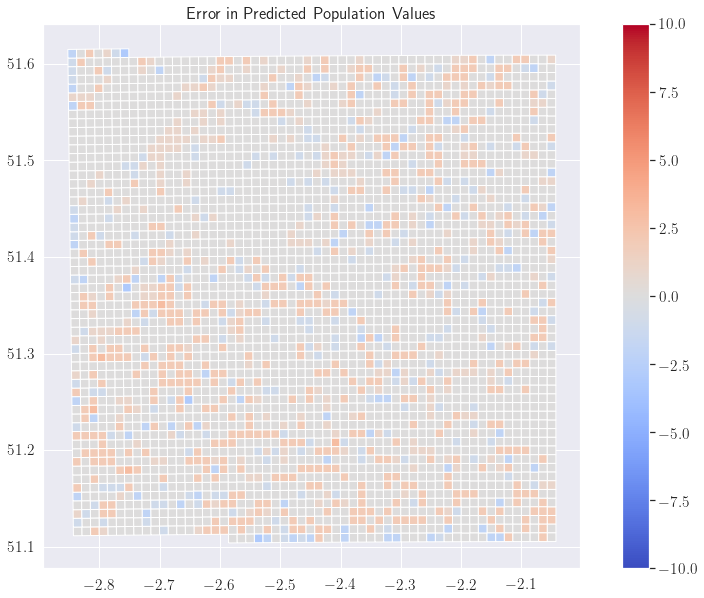

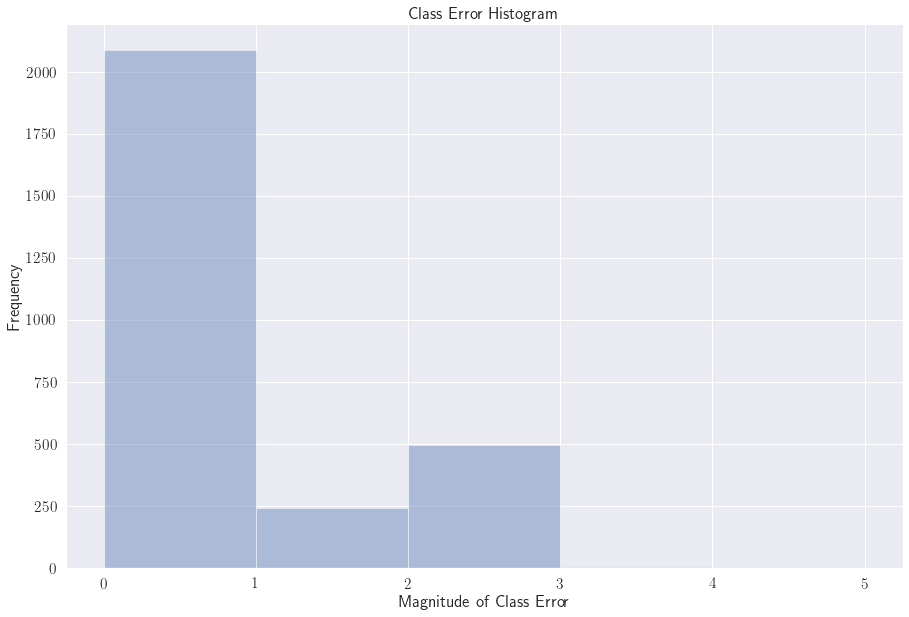

,Index,Population,Pred Class,Actual Class,Class Error,geometry
0,701240,0.0,0,0.0,0.0,"MULTIPOLYGON (((-2.80115 51.17466, -2.80130 51..."
1,701241,0.0,0,0.0,0.0,"MULTIPOLYGON (((-2.78685 51.17475, -2.78700 51..."
2,701242,0.0,2,0.0,2.0,"MULTIPOLYGON (((-2.77254 51.17485, -2.77269 51..."
3,701243,0.0,3,0.0,3.0,"MULTIPOLYGON (((-2.75824 51.17494, -2.75838 51..."
4,701244,0.0,2,0.0,2.0,"MULTIPOLYGON (((-2.74393 51.17504, -2.74407 51..."
...,...,...,...,...,...,...
3120,930,6397.0,4,4.0,0.0,"MULTIPOLYGON (((-2.53257 51.45497, -2.53267 51..."
3121,7290,2815.0,4,4.0,0.0,"MULTIPOLYGON (((-2.56124 51.44584, -2.56135 51..."
3122,318,9281.0,4,4.0,0.0,"MULTIPOLYGON (((-2.61892 51.45454, -2.61904 51..."
3123,304,9365.0,4,4.0,0.0,"MULTIPOLYGON (((-2.61904 51.46353, -2.61916 51..."


In [ ]:
shapefile_cl(model_results_tst, classes=6)

## Model - from scratch

### Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model1 = Neural_Network(config='16', batch_norm=True, mode='cla-6')

model1 = model1.float()
model1.to(device)

summary(model1, input_size=(7,50,33))

print("Model Loaded")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 33]           4,096
       BatchNorm2d-2           [-1, 64, 50, 33]             128
              ReLU-3           [-1, 64, 50, 33]               0
            Conv2d-4           [-1, 64, 50, 33]          36,928
       BatchNorm2d-5           [-1, 64, 50, 33]             128
              ReLU-6           [-1, 64, 50, 33]               0
         MaxPool2d-7           [-1, 64, 25, 16]               0
            Conv2d-8          [-1, 128, 25, 16]          73,856
       BatchNorm2d-9          [-1, 128, 25, 16]             256
             ReLU-10          [-1, 128, 25, 16]               0
           Conv2d-11          [-1, 128, 25, 16]         147,584
      BatchNorm2d-12          [-1, 128, 25, 16]             256
             ReLU-13          [-1, 128, 25, 16]               0
        MaxPool2d-14           [-1, 128

In [ ]:
model1_result = run_training(model1,
                            dataset=train_dataset_model,
                            t_loader=train_loader,
                            v_loader=val_loader,
                            max_epochs=50,
                            initial_lr=0.001,
                            flip=True,
                            flip_prob=0.25,
                            pbar=False,
                            checkpoint=False,
                            save_as="classification_6classes",
                            weight_decay=1e-5)

Epoch: 1
Training   | Avg loss: 1.4883 | Accuracy: 32.37% | Fbeta: 0.1226
Validation | Avg loss: 1.4986 | Accuracy: 31.87% | Fbeta: 0.1205
Epoch: 2
Training   | Avg loss: 1.0584 | Accuracy: 55.36% | Fbeta: 0.3752
Validation | Avg loss: 1.0752 | Accuracy: 55.47% | Fbeta: 0.3773
Epoch: 3
Training   | Avg loss: 0.9499 | Accuracy: 61.10% | Fbeta: 0.4213
Validation | Avg loss: 0.9588 | Accuracy: 61.24% | Fbeta: 0.4234
Epoch: 4
Training   | Avg loss: 0.8437 | Accuracy: 65.77% | Fbeta: 0.4592
Validation | Avg loss: 0.8427 | Accuracy: 66.08% | Fbeta: 0.4626
Epoch: 5
Training   | Avg loss: 0.8374 | Accuracy: 66.22% | Fbeta: 0.4516
Validation | Avg loss: 0.8323 | Accuracy: 66.21% | Fbeta: 0.4537
Epoch: 6
Training   | Avg loss: 0.8350 | Accuracy: 63.30% | Fbeta: 0.5364
Validation | Avg loss: 0.8369 | Accuracy: 62.03% | Fbeta: 0.5176
Epoch: 7
Training   | Avg loss: 0.7971 | Accuracy: 67.79% | Fbeta: 0.5199
Validation | Avg loss: 0.8040 | Accuracy: 67.53% | Fbeta: 0.5179
Epoch: 8
Training   | Avg l

In [ ]:
parameters = torch.load('/content/drive/My Drive/Dissertation Files/Models/classification_6classes_LowestLossEpoch24')
model1.load_state_dict(parameters['model'])

<All keys matched successfully>

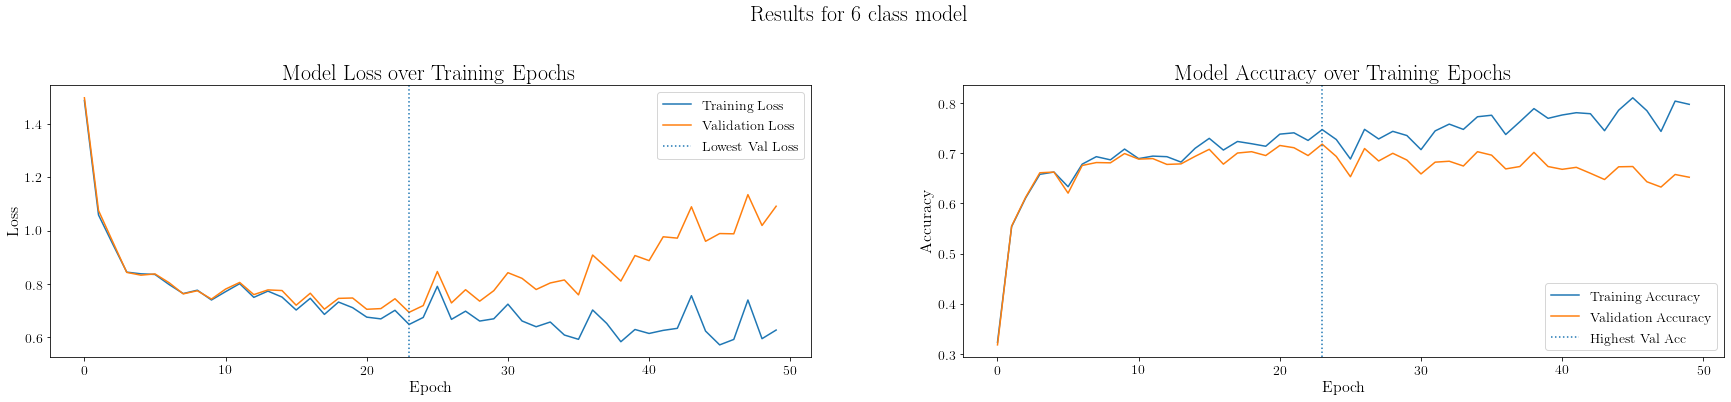

Lowest Validation Loss: 0.6928 - Epoch: 23
Highest Validation Accuracy: 71.7632% - Epoch 23


In [ ]:
small_fonts()
plot_results_cl(model1_result, "Results for 6 class model")

### Results

In [ ]:
train_dataset_model.flip = False
model1_result_tr = test_classification(model1, train_dataset_model, train_dataset_model.n_images, device)

Overall Accuracy (Top 1, Top 2, Top 3): 87.448018%, 94.743907%, 97.025846%
    
Accuracy: 87.45%
    
Balanced Accuracy: 79.19%
    
F1 Score: 0.87
    

    
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.89      8185
         1.0       0.38      0.34      0.36      2204
         2.0       0.84      0.93      0.88     11271
         3.0       0.92      0.90      0.91      8474
         4.0       0.93      0.98      0.95      7631
         5.0       0.90      0.78      0.84       229

    accuracy                           0.87     37994
   macro avg       0.82      0.79      0.80     37994
weighted avg       0.87      0.87      0.87     37994



In [ ]:
model1_results_tst = test_classification(model1, test_dataset, test_dataset.n_images, device)

Overall Accuracy (Top 1, Top 2, Top 3): 59.917160%, 70.343195%, 80.970414%
    
Accuracy: 59.92%
    
Balanced Accuracy: 48.38%
    
F1 Score: 0.61
    

    
              precision    recall  f1-score   support

         0.0       0.78      0.59      0.67      3065
         1.0       0.19      0.22      0.20       886
         2.0       0.46      0.61      0.52      2008
         3.0       0.65      0.60      0.62      1292
         4.0       0.88      0.89      0.88      1192
         5.0       0.00      0.00      0.00         7

    accuracy                           0.60      8450
   macro avg       0.49      0.48      0.48      8450
weighted avg       0.63      0.60      0.61      8450



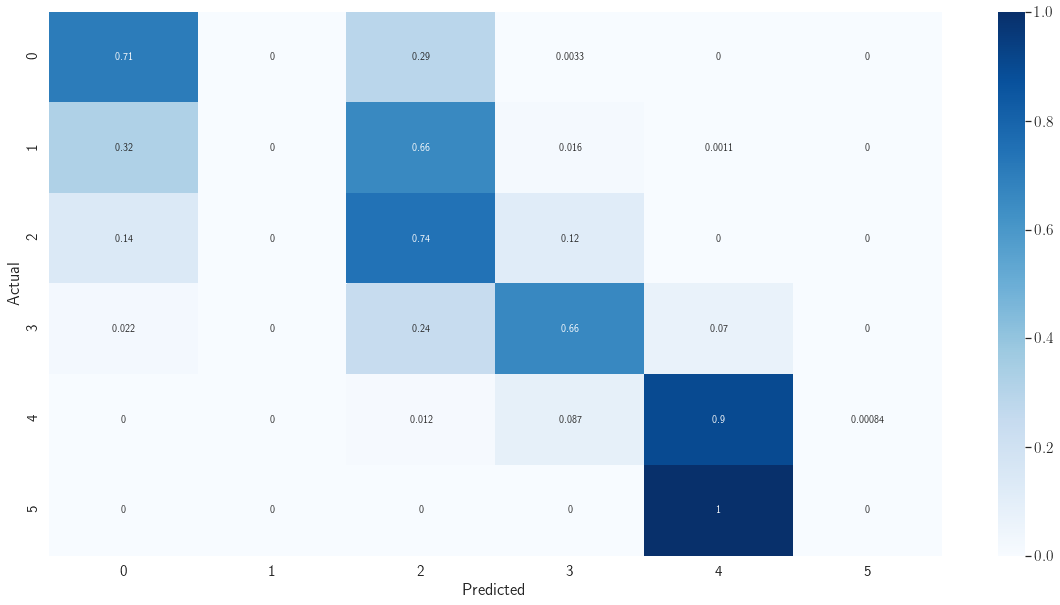

In [ ]:
confusion_matrix(model1_results_tst)

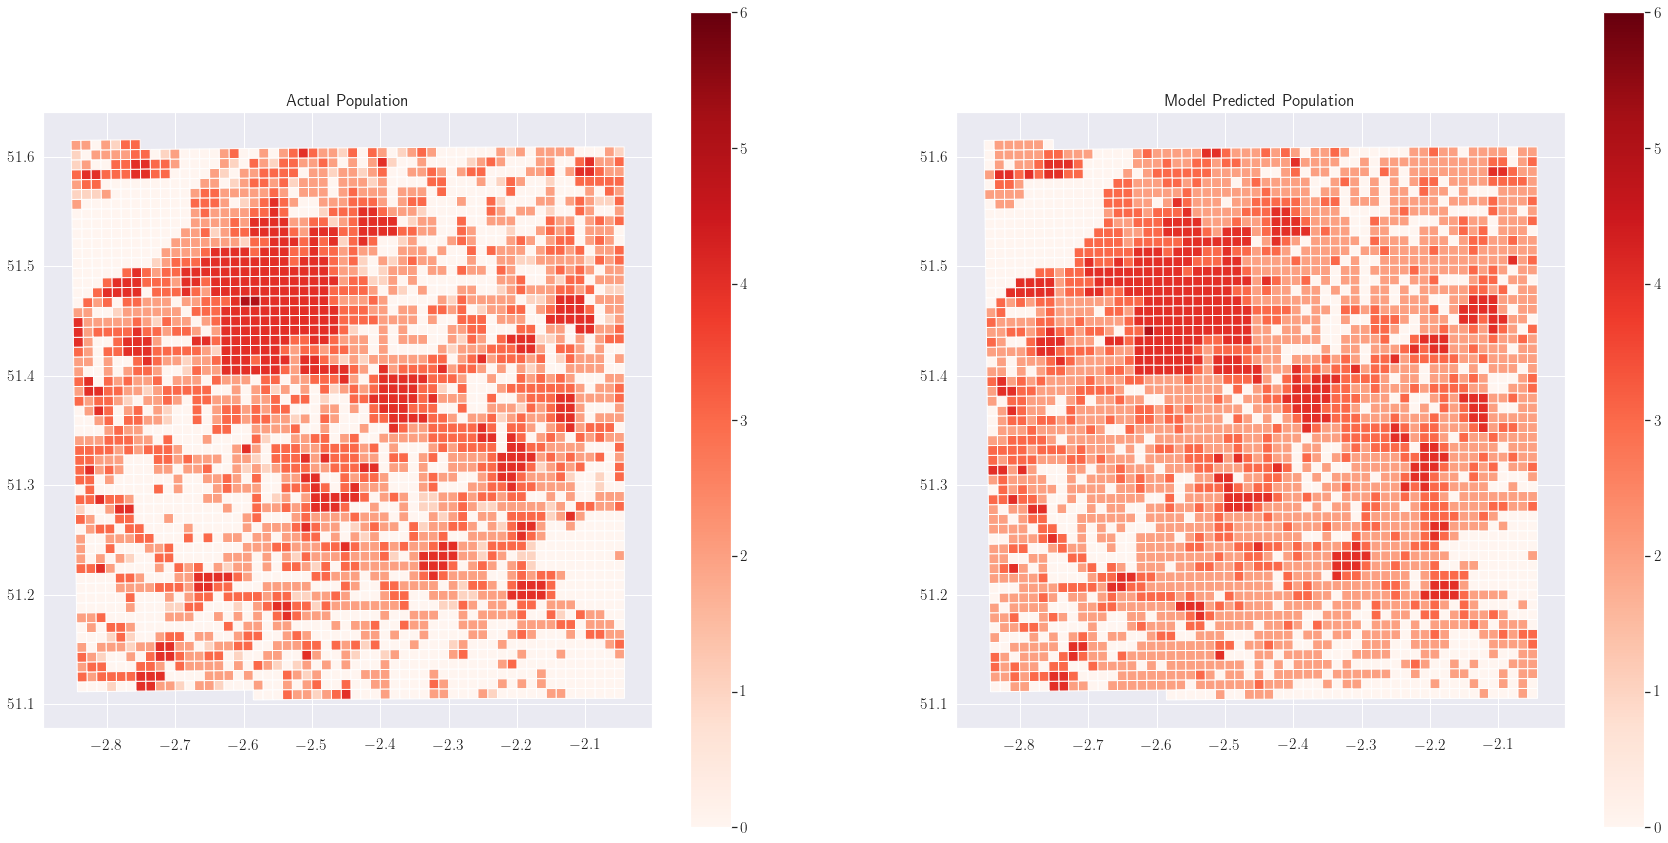

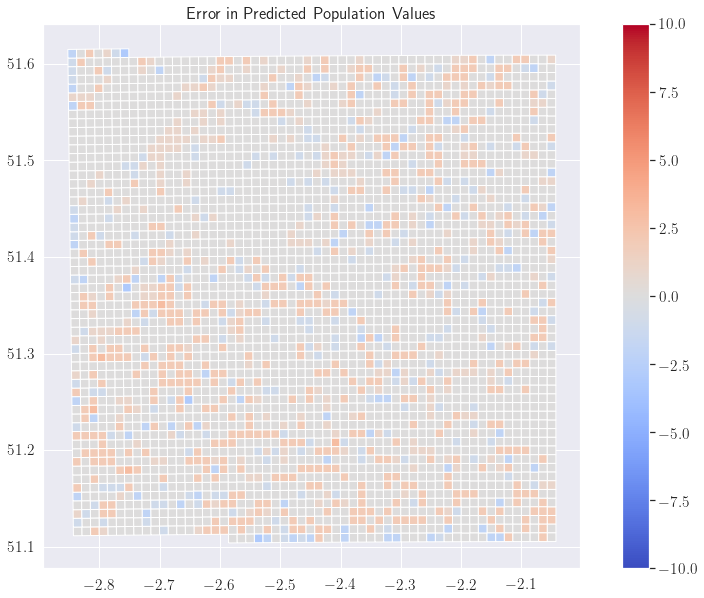

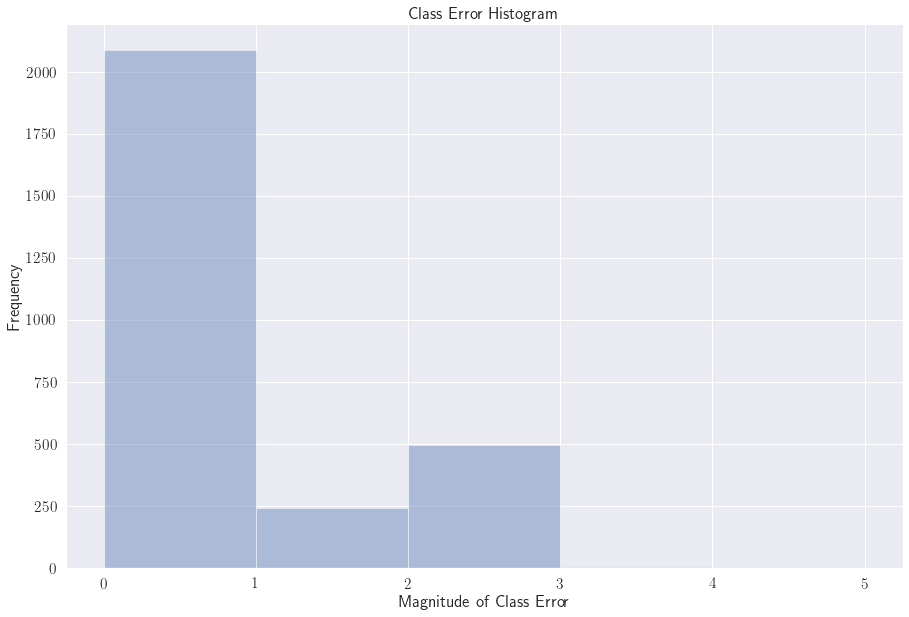

,Index,Population,Pred Class,Actual Class,Class Error,geometry
0,701240,0.0,0,0.0,0.0,"MULTIPOLYGON (((-2.80115 51.17466, -2.80130 51..."
1,701241,0.0,0,0.0,0.0,"MULTIPOLYGON (((-2.78685 51.17475, -2.78700 51..."
2,701242,0.0,2,0.0,2.0,"MULTIPOLYGON (((-2.77254 51.17485, -2.77269 51..."
3,701243,0.0,3,0.0,3.0,"MULTIPOLYGON (((-2.75824 51.17494, -2.75838 51..."
4,701244,0.0,2,0.0,2.0,"MULTIPOLYGON (((-2.74393 51.17504, -2.74407 51..."
...,...,...,...,...,...,...
3120,930,6397.0,4,4.0,0.0,"MULTIPOLYGON (((-2.53257 51.45497, -2.53267 51..."
3121,7290,2815.0,4,4.0,0.0,"MULTIPOLYGON (((-2.56124 51.44584, -2.56135 51..."
3122,318,9281.0,4,4.0,0.0,"MULTIPOLYGON (((-2.61892 51.45454, -2.61904 51..."
3123,304,9365.0,4,4.0,0.0,"MULTIPOLYGON (((-2.61904 51.46353, -2.61916 51..."


In [ ]:
shapefile_cl(model1_results_tst, classes=6)